In [80]:
import pandas as pd
from joblib import load
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, ConfusionMatrixDisplay

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [60]:
from sklearn.utils import shuffle

In [61]:
scaler = load("MaxAbsScaler/scaler_MaxAbsScaler.joblib")

In [62]:
df_train = pd.read_csv("MaxAbsScaler/X_train_MaxAbsScaler.csv")
df_train = df_train.dropna()

In [110]:
df_positive = df_train[df_train["label_gdm"] == 1]
df_negative = df_train[df_train["label_gdm"] == 0]

df_negative = shuffle(df_negative, random_state=42, n_samples=len(df_positive))

df_train = pd.concat([df_positive, df_negative], axis=0)

In [ ]:
pca_instance = PCA(random_state=42)
pca_instance.fit(df_train.drop(columns=["label_gdm"]))
pca_data_transform = pca_instance.transform(df_train.drop(columns=["label_gdm"]))

In [83]:
tsne_instance = TSNE(random_state=42)
tsn_data_transform = tsne_instance.fit_transform(df_train.drop(columns=["label_gdm"]))

In [64]:
df_test = pd.read_csv("divided_data/X_test.csv")
df_test = df_test.dropna()

test_response = df_train["label_gdm"].values
test_values = df_train.drop(columns=["label_gdm"]).values
test_values = scaler.transform(test_values)


/home/david/miniconda3/envs/machine_learning_2025/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MaxAbsScaler was fitted with feature names
  warnings.warn(


In [111]:
response = df_train["label_gdm"].values
df_values = df_train.drop(columns=["label_gdm"]).values
df_values_pca = pca_data_transform
df_values_tsne = tsn_data_transform

In [85]:
rf_instance = RandomForestClassifier(random_state=42)

In [86]:
parameters_of_rf = {
    "n_estimators" : [50, 100, 150, 200, 500, 1000],
    "criterion" : ['gini', 'entropy', 'log_loss'],
    "max_features" : ['sqrt', 'log2']
}

In [87]:
clf = GridSearchCV(rf_instance, parameters_of_rf, n_jobs=-1, scoring='f1_weighted')

In [97]:
clf.fit(tsn_data_transform, response)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy', ...], 'max_features': ['sqrt', 'log2'], 'n_estimators': [50, 100, ...]}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,1000


In [98]:
clf.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 1000}

In [99]:
clf.best_score_

np.float64(0.5101130328676312)

In [100]:
rf_model = RandomForestClassifier(**clf.best_params_)
rf_model.fit(tsn_data_transform, response)

,n_estimators,1000
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [79]:
df_importances = pd.DataFrame()
df_importances["feature"] = rf_model.feature_names_in_
df_importances["importance"] = rf_model.feature_importances_
df_importances.sort_values(by="importance", ascending=False)

,feature,importance
6,fpg_mmol_l,0.134980
10,triglycerides_mmol_l,0.100594
7,hba1c_percent,0.081134
11,hdl_mmol_l,0.068412
0,age_years,0.063307
9,homa_ir,0.063072
2,systolic_bp_mmHg,0.062710
4,map_mmHg,0.061690
8,insulin_uIU_ml,0.060576
5,gestational_weeks,0.059888


In [101]:
predict_test = rf_model.predict(tsne_instance.fit_transform(test_values))

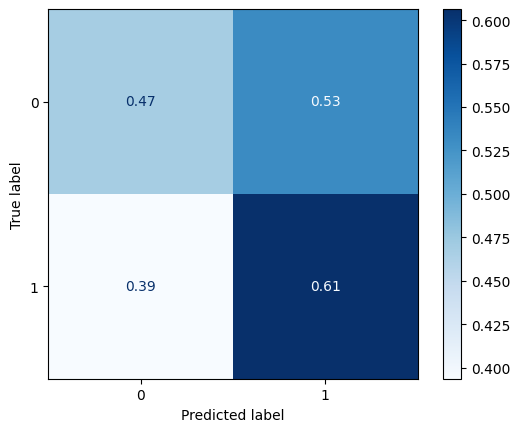

In [102]:
ConfusionMatrixDisplay.from_estimator(
    estimator=rf_model,
    X=tsne_instance.fit_transform(test_values),
    y=test_response,
    cmap="Blues",
    normalize="true"
)

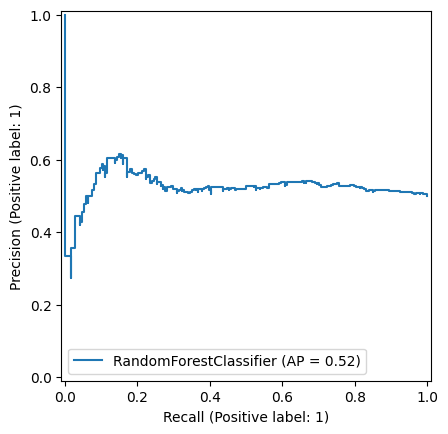

In [103]:
PrecisionRecallDisplay.from_estimator(
    estimator=rf_model,
    X=tsne_instance.fit_transform(test_values),
    y=test_response,
)

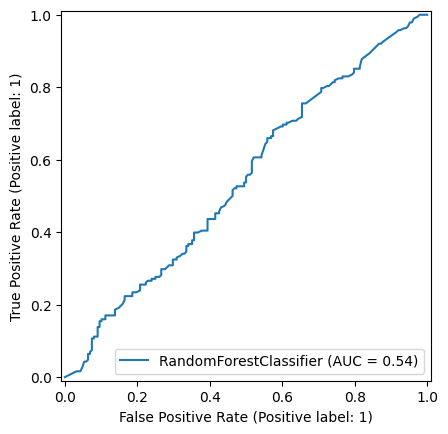

In [104]:
RocCurveDisplay.from_estimator(
    estimator=rf_model,
    X=tsne_instance.fit_transform(test_values),
    y=test_response,
)

In [109]:
import tpot
from tpot import TPOTClassifier
import sklearn

In [108]:
classification_optimizer = TPOTClassifier()

In [112]:
scorer = sklearn.metrics.get_scorer('roc_auc_ovr')

est = tpot.TPOTClassifier(
    scorers=[scorer, tpot.objectives.complexity_scorer],
    scorers_weights=[1.0, -1.0],
    search_space="linear",
    n_jobs=4, 
    max_time_mins=60, 
    max_eval_time_mins=10,
    early_stop=2,
    verbose=2,)

est.fit(df_values, response)

Generation: : 9it [09:30, 63.43s/it] 


,search_space,<tpot.search_...x7c2880405400>
,scorers,"[make_scorer(r...lti_class=ovr), <function com...x7c288068dee0>]"
,scorers_weights,"[1.0, -1.0]"
,cv,10
,other_objective_functions,[]
,other_objective_functions_weights,[]
,objective_function_names,None
,bigger_is_better,True
,categorical_features,None
,memory,None
,preprocessing,False


In [116]:
est.selected_best_score

roc_auc_score                                                   0.769606
complexity_scorer                                                  800.2
Parents                                                         (86, 86)
Variation_Function                                            ind_mutate
Individual             <tpot.search_spaces.pipelines.sequential.Seque...
Generation                                                           6.0
Submitted Timestamp                                     1763058968.46142
Completed Timestamp                                     1763058969.16602
Eval Error                                                          None
Pareto_Front                                                         1.0
Instance               (RobustScaler(quantile_range=(0.2923397073625,...
Name: 333, dtype: object

In [114]:
est.fitted_pipeline_

,steps,"[('robustscaler', ...), ('passthrough', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,with_centering,True
,with_scaling,True
,quantile_range,"(0.2923397073625, ...)"
,copy,True
,unit_variance,False
,transformer_list,"[('skiptransformer', ...), ('passthrough', ...)]"
,n_jobs,None


/home/david/miniconda3/envs/machine_learning_2025/lib/python3.13/site-packages/sklearn/metrics/_plot/roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


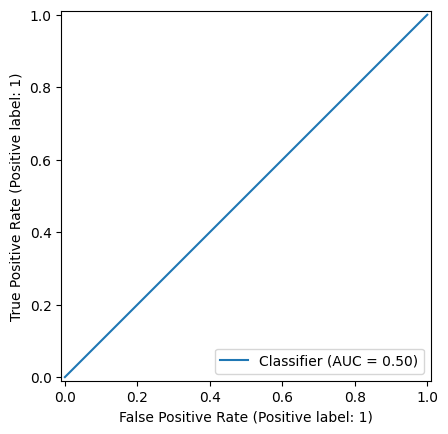

In [115]:
RocCurveDisplay.from_predictions(
    y_true=test_response,
    y_pred=est.fitted_pipeline_.predict(test_values)
)